In [0]:
!sudo apt-get update
!sudo apt-get install tesseract-ocr
!sudo apt-get install libtesseract-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 1s (260 kB/s)
Reading package lists... Done
Reading package lists... Done
Building de

In [0]:
!pip install tesseract
!pip install tesseract-ocr
!pip install pytesseract

In [0]:
import cv2
import pytesseract
import numpy as np
import imutils
from google.colab.patches import cv2_imshow

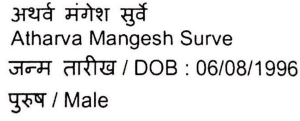

In [0]:
img=cv2.imread('aadhar_name2.jpg')
img = imutils.resize(img, width=300)
cv2_imshow(img)

In [0]:
img.shape

(121, 300, 3)

In [0]:
custom_config = r'-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz --psm 6'
junk_list=pytesseract.image_to_string(img, config=custom_config).splitlines()
aadhar_details={'Name':junk_list[2],
                'Date of Birth':junk_list[4].rpartition(':')[-1],
                'Gender':junk_list[5].rpartition('/')[-1]}
print(aadhar_details)

{'Name': 'Atharva Mangesh Surve', 'Date of Birth': ' 06/08/1996', 'Gender': ' Male'}


In [0]:
custom_config = r'-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz --psm 6'
pytesseract.image_to_string(image, config=custom_config).splitlines()

['Bee ee nT ee ee cee eS ery',
 'anda ~',
 '2 = WG overniientorinaiame———',
 'wen tore Fert',
 'Soham Sanjay Mhatre',
 '‘ eA FART / DOB : 17/03/1999 params ny',
 'a re a eS',
 '; Jee / Male ee',
 '8706 7751 4240 4',
 'HU - HA Heat ar HH']

In [0]:
image1=cv2.imread('testqr2.jpg')
image1= imutils.resize(image1, width=600)

13


In [0]:
custom_config = r'-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz --psm 6'
pytesseract.image_to_string(image1, config=custom_config).splitlines()

['ua',
 'CORI',
 'SGCovernmentotindiaz=——=-',
 '7 arg Ae at',
 'Atharva Mangesh Surve',
 '3-H arta / DOB : 06/08/1996',
 '| FST / Male . on',
 'way? Pages',
 'pets',
 'i Bees am',
 '| pee ey',
 '4981 3440 4185',
 'AIS 37, Arsh soar']

# QR CODE STARTS HERE

Erosions,Dilations (6,4) work for width 600 using imutils for detecting the QR code.

In [0]:
def process_thresh_qr(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  (x,thresh)=cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
  return thresh

def Scharr_grad_qr(thresh):
  # compute the Scharr gradient magnitude representation of the images
  # in both the x and y direction
  gradX = cv2.Sobel(thresh, ddepth = cv2.CV_32F, dx = 1, dy = 0, ksize = -1)
  gradY = cv2.Sobel(thresh, ddepth = cv2.CV_32F, dx = 0, dy = 1, ksize = -1)
  # subtract the y-gradient from the x-gradient
  gradient = cv2.subtract(gradX, gradY)
  gradient = cv2.convertScaleAbs(gradient)
  return gradient

def morph_qr(gradient):
  # construct a closing kernel and apply it to the thresholded image
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 7))
  closed = cv2.morphologyEx(gradient, cv2.MORPH_CLOSE, kernel)
  return closed  

def erode_dilate_qr(closed):
  # perform a series of erosions and dilations
  closed = cv2.erode(closed, None, iterations = 6)
  closed = cv2.dilate(closed, None, iterations = 4)
  return closed

def countour_qr(closed,image):
  # find the contours in the thresholded image, then sort the contours
  # by their area, keeping only the largest one
  (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
  # compute the rotated bounding box of the largest contour
  rect = cv2.minAreaRect(c)
  box = np.int0(cv2.boxPoints(rect))
  # draw a bounding box arounded the detected barcode and display the image
  fin_img=cv2.drawContours(image, [box], -1, (0, 255, 0), 1)
  return fin_img,box  

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    #print(rect)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0])**2) + ((br[1] - bl[1])**2))
    widthB = np.sqrt(((tr[0] - tl[0])**2) + ((tr[1] - tl[1])**2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0])**2) + ((tr[1] - br[1])**2))
    heightB = np.sqrt(((tl[0] - bl[0])**2) + ((tl[1] - bl[1])**2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped


In [0]:
image=cv2.imread('aadhar.jpg')
image = imutils.resize(image, width=600)

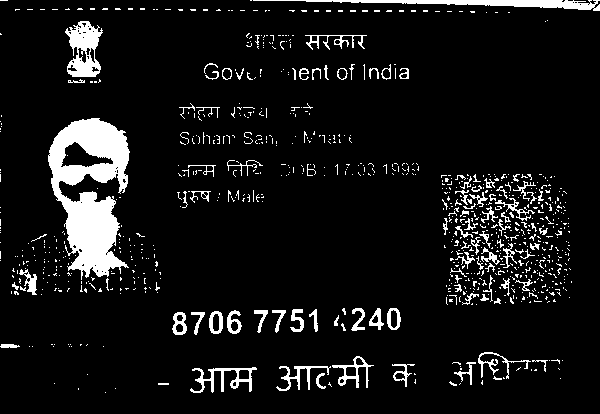

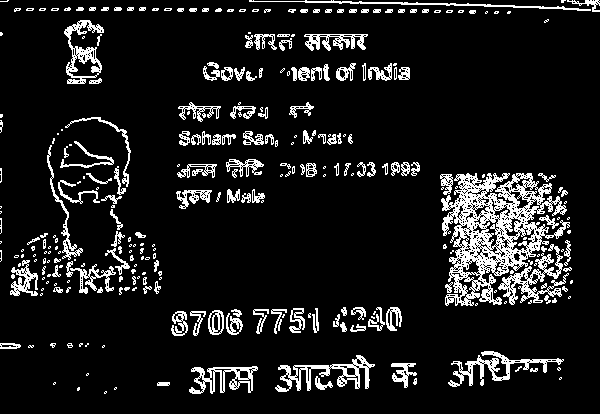

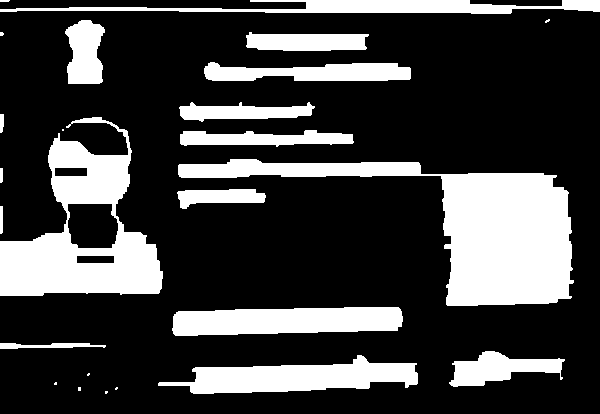

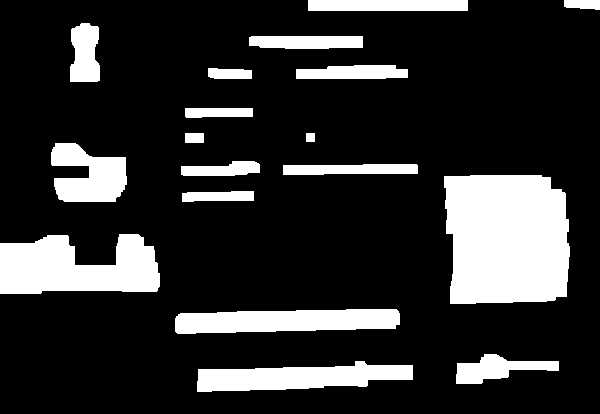

-1

In [0]:
thresh_qr=process_thresh_qr(image)
cv2_imshow(thresh_qr)
cv2.waitKey(0)

grad_qr=Scharr_grad_qr(thresh_qr)
cv2_imshow(grad_qr)
cv2.waitKey(0)

morph_img=morph_qr(grad_qr)
cv2_imshow(morph_img)
cv2.waitKey(0)

ero_dil=erode_dilate_qr(morph_img)
cv2_imshow(ero_dil)
cv2.waitKey(0)


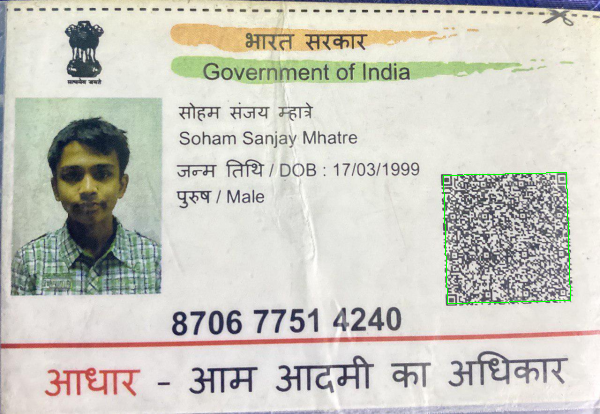

In [0]:
fin_img,box=countour_qr(ero_dil,image)
cv2_imshow(fin_img)

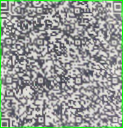

In [0]:
qr = four_point_transform(fin_img, box)
cv2_imshow(qr)

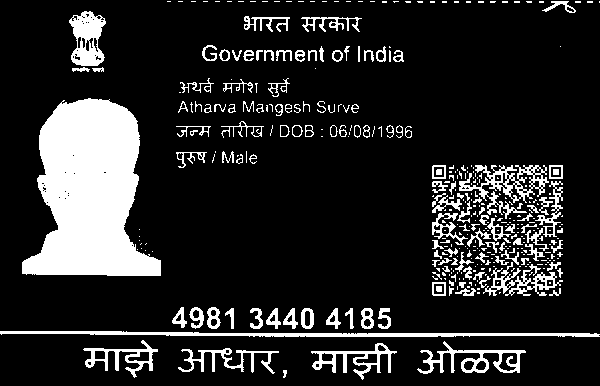

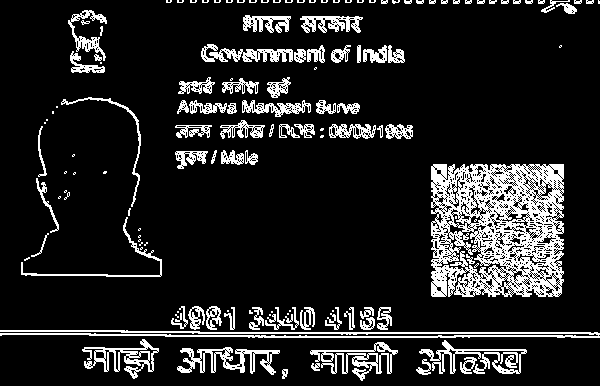

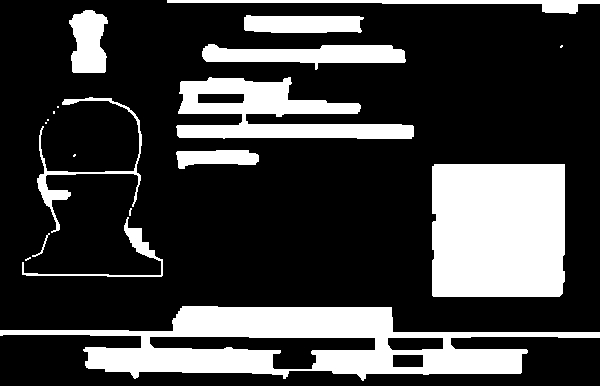

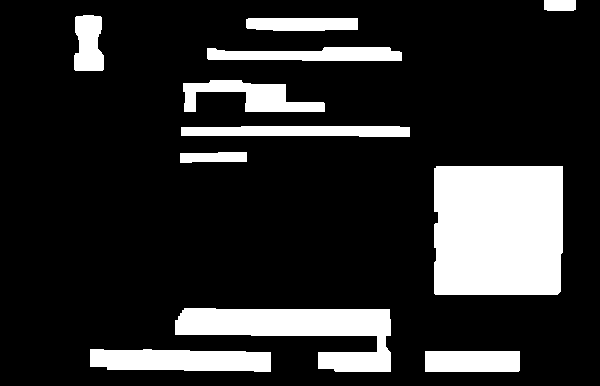

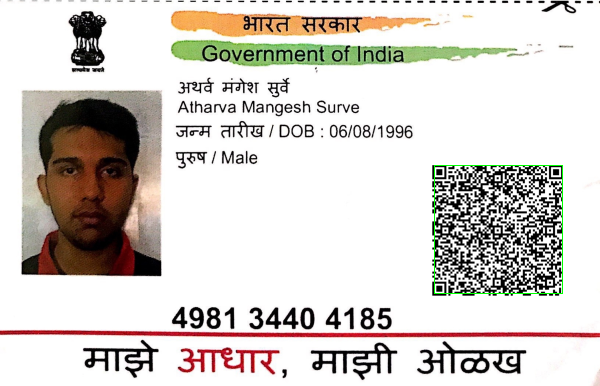

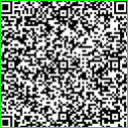

-1

In [0]:
image=cv2.imread('testqr2.jpg')
image = imutils.resize(image, width=600)

thresh_qr=process_thresh_qr(image)
cv2_imshow(thresh_qr)
cv2.waitKey(0)

grad_qr=Scharr_grad_qr(thresh_qr)
cv2_imshow(grad_qr)
cv2.waitKey(0)

morph_img=morph_qr(grad_qr)
cv2_imshow(morph_img)
cv2.waitKey(0)

ero_dil=erode_dilate_qr(morph_img)
cv2_imshow(ero_dil)
cv2.waitKey(0)

fin_img,box=countour_qr(ero_dil,image)
cv2_imshow(fin_img)
cv2.waitKey(0)

qr = four_point_transform(fin_img, box)
cv2_imshow(qr)
cv2.waitKey(0)

In [0]:
def img_to_qr(image):
  image = imutils.resize(image, width=600)
  thresh_qr=process_thresh_qr(image)
  grad_qr=Scharr_grad_qr(thresh_qr)
  morph_img=morph_qr(grad_qr)
  ero_dil=erode_dilate_qr(morph_img)
  fin_img,box=countour_qr(ero_dil,image)
  qr = four_point_transform(fin_img, box)
  return qr

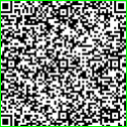

In [0]:
cv2_imshow(img_to_qr(image))